# Notebook for zonals analysis of generated climate by GANs. 

This notebook describes how to produce the figures in the article [Producing realistic climate data using GAN](https://npg.copernicus.org/articles/28/347/2021/npg-28-347-2021.html)

One should note that this repository shows the code but due to the size of the dataset the figures were reproduced with reduced dataset. Consequently, the quality of the statistical analysis is impacted. Data were created by running the Plasim simulator, for further details see the article. 

The dataset is composed of the daily images of different variable (temperature, wind components, humidity...) on a 64 by 128 pixel grid with 10 levels of altitude over the globe, projected using the PlateCarre projection. These images were standardized with respect to each variable and each level of altitude, the mean and std are stored in the "scaling" dataset.  

In [1]:
#Import of necessary packages and memory allocation.

%matplotlib inline
import tensorflow as tf
import keras 
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth = True
#config.gpu_options.visible_device_list = str(3)
set_session(tf.Session(config=config))

import h5py as h5
import pandas as pd
from keras.models import load_model
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.util
import sys
import seaborn as sns
import math


/home/besombes/.env/old_tf1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/besombes/.env/old_tf1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/besombes/.env/old_tf1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/besombes/.env/old_tf1/lib/python3.7/site-packages/tensorflow/

/home/besombes/.env/old_tf1/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/besombes/.env/old_tf1/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/besombes/.env/old_tf1/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/besombes/.env/old_tf1/lib/python3.7/site

In [2]:
#Plot parameters.

from matplotlib import rc
sns.set() #Seaborn theme 
font = {'family' : 'normal','weight' : 'bold', 'size'   : 22}
tick_size = 20
fontweight = 'bold'
#lab_loc = 2
#lab_font_size = 14
#rc('text', usetex=True)
matplotlib.rc('font', **font)
plt.style.use('seaborn')

In [3]:
# Paths

data_file = 'data_plasim_3y_sc.h5' # Dataset filename 

## Notebook parameters. 

Setting up parameters for :
  - Figure generation.
  - Number of samples considered for the statistical analysis (Here very low for computational purpose).
  - Longitude and latitude of grid cells.
  - Different names of the GAN training save.

In [4]:
#########
multi_train = True  #If the training was in multiple run : True
plot_var = True     #True: plot all cells result ; False : manualy change if plot_var in if True: to plot
save = False         
scale = False
#########
N_fields = 82      #Number of fields == Number of channels in generated tensor. 
N_lvls = 10         #Number of pressure level for 3D variable. 

N_gen = 365     #Number of generation used for statistic analysis /!\ Memory usage important /!\
N_train = 365
#indxs = np.random.randint(0,1000,N_gen)
#ind = indxs[0]
#########
lons = np.genfromtxt('../data/raw/lon.csv', delimiter=',')
lat = np.genfromtxt('../data/raw/lat.csv', delimiter=',')

print(lons)
lon_idx = [16,16,32,48]                    #France, north america, ecuador, south america
lat_idx = [5,106,106,106]                  #France, north america, ecuador, south america
fnes = [[16,5],[16,106],[32,106],[48,106]] #Coordinate for distribution comparison at different locations.
L_ind = ['a','b','c','d']


if N_fields==82:
    runnumber_0 = 'RESNET_V8_82l'
    runnumber_1, stop1 = 'RESNET_V8_82l_continue1', 8000 #Name of the generator save file for the 1st restart
    runnumber_2, stop2 = 'RESNET_V8_82l_continue2', 15500 #Name of the generator save file for the 2nd restart
    runnumber_3, stop3 = 'RESNET_V8_82l_continue3b', 23250
    runnumber_4, stop4 = 'RESNET_V8_82l_continue4', 31000
    runnumber = runnumber_4 #Most recent save
elif N_fields==22:
    runnumber_0 = 'RESNET_V8_gual_Gbn'
    runnumber = runnumber_0 #Most recent save







[  0.       2.8125   5.625    8.4375  11.25    14.0625  16.875   19.6875
  22.5     25.3125  28.125   30.9375  33.75    36.5625  39.375   42.1875
  45.      47.8125  50.625   53.4375  56.25    59.0625  61.875   64.6875
  67.5     70.3125  73.125   75.9375  78.75    81.5625  84.375   87.1875
  90.      92.8125  95.625   98.4375 101.25   104.0625 106.875  109.6875
 112.5    115.3125 118.125  120.9375 123.75   126.5625 129.375  132.1875
 135.     137.8125 140.625  143.4375 146.25   149.0625 151.875  154.6875
 157.5    160.3125 163.125  165.9375 168.75   171.5625 174.375  177.1875
 180.     182.8125 185.625  188.4375 191.25   194.0625 196.875  199.6875
 202.5    205.3125 208.125  210.9375 213.75   216.5625 219.375  222.1875
 225.     227.8125 230.625  233.4375 236.25   239.0625 241.875  244.6875
 247.5    250.3125 253.125  255.9375 258.75   261.5625 264.375  267.1875
 270.     272.8125 275.625  278.4375 281.25   284.0625 286.875  289.6875
 292.5    295.3125 298.125  300.9375 303.75   306.5

Here _X_train has a size of (samples, latitude, longitudes, variable). Variable has a size of 82 due to the different variables at differents altitude levels. Below the name of the different channels are printed : ta_z100 is for example the temperature at the pressure level 100 hPa i.e. at the surface. There is 8 different variables on the 10 pressure levels plus the surface pressure.  

In [5]:
# Loading dataset and scaling factors (N_fields, 2)= mean and variance for each channel.

f=h5.File(f'../data/raw/{data_file}','r')
_X_train = f['dataset']
scaling = f['scaling'][:,:]
print(scaling.shape)

(81, 2)


In [6]:
var = ['ta', 'ua', 'va', 'hus', 'wap', 'zeta', 'd', 'zg']
lvls = [100, 200,300,400,500,600,700,800,900,1000]

chan_titles = []
for i in var:
    for j in lvls:
        chan_titles.append(i+'_z'+str(j))
chan_titles.append('surface pressure')
#chan_titles.append('latitude')

print(chan_titles)

['ta_z100', 'ta_z200', 'ta_z300', 'ta_z400', 'ta_z500', 'ta_z600', 'ta_z700', 'ta_z800', 'ta_z900', 'ta_z1000', 'ua_z100', 'ua_z200', 'ua_z300', 'ua_z400', 'ua_z500', 'ua_z600', 'ua_z700', 'ua_z800', 'ua_z900', 'ua_z1000', 'va_z100', 'va_z200', 'va_z300', 'va_z400', 'va_z500', 'va_z600', 'va_z700', 'va_z800', 'va_z900', 'va_z1000', 'hus_z100', 'hus_z200', 'hus_z300', 'hus_z400', 'hus_z500', 'hus_z600', 'hus_z700', 'hus_z800', 'hus_z900', 'hus_z1000', 'wap_z100', 'wap_z200', 'wap_z300', 'wap_z400', 'wap_z500', 'wap_z600', 'wap_z700', 'wap_z800', 'wap_z900', 'wap_z1000', 'zeta_z100', 'zeta_z200', 'zeta_z300', 'zeta_z400', 'zeta_z500', 'zeta_z600', 'zeta_z700', 'zeta_z800', 'zeta_z900', 'zeta_z1000', 'd_z100', 'd_z200', 'd_z300', 'd_z400', 'd_z500', 'd_z600', 'd_z700', 'd_z800', 'd_z900', 'd_z1000', 'zg_z100', 'zg_z200', 'zg_z300', 'zg_z400', 'zg_z500', 'zg_z600', 'zg_z700', 'zg_z800', 'zg_z900', 'zg_z1000', 'surface pressure']


## Generator loading

In the following cells the trained generator of the GAN model is loaded. The custom_objects parameter is the custom layers inside the generator that needs to be redefine at the loading. 

In [7]:
sys.path.append('../src/modeling')
sys.path.append('../src/preprocessing')
sys.path.append('../src/preparation')
from SpectralNormalizationKeras import ConvSN2D, DenseSN
from custom_classes import NearestPadding2D, WrapPadding2D

gen = load_model(f'../model/{runnumber}_generator.h5',
                 custom_objects = {'NearestPadding2D': NearestPadding2D,
                                   'WrapPadding2D': WrapPadding2D,
                                   'DenseSN' :DenseSN,
                                   'ConvSN2D': ConvSN2D})


2022-05-18 10:32:57.206548: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or set the envvar XLA_FLAGS=--xla_hlo_profile.
/home/besombes/.env/old_tf1/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
print('Generating samples...')

z = np.random.normal(0,1,(N_gen,64))
fk_imgs = gen.predict(z)
print('Samples generated.')
print('scaling...')
fk_imgs = np.multiply(fk_imgs[:,:,:,:-1],
                    scaling[np.newaxis,:,1]) + scaling[np.newaxis,:,0]
print('scaled.')

print('Scaling...')
X_train = np.multiply(_X_train[:N_train,:,:,:],
                    scaling[np.newaxis,:,1]) + scaling[np.newaxis,:,0]
print('Scaled')

noise_ = np.load('../data/raw/noise_.npy') # Loads a noise vector studied in the article.
im = gen.predict(noise_)
im_sc = np.multiply(im[:,:,:,:-1],
                    scaling[np.newaxis,:,1]) + scaling[np.newaxis,:,0]

# Add a column at a side of the image to enforce periodic boundary condition 
# at the vertical side of the image.

X_train, lon = cartopy.util.add_cyclic_point(X_train, coord=lons, axis=2)
fk_imgs, lon = cartopy.util.add_cyclic_point(fk_imgs, coord=lons, axis=2)
im, lon = cartopy.util.add_cyclic_point(im, coord=lons, axis=2)
im_sc, lon = cartopy.util.add_cyclic_point(im_sc, coord=lons, axis=2)

Generating samples...
Samples generated.
scaling...
scaled.
Scaling...
Scaled


In [21]:
ind = 10
indx, indf = ind, 0
print(ind)

10


The two climate situations chosen with the `noise_` vector and the `ind` variable shows a geopotential minimum over the Northern Europe (see plot below). 

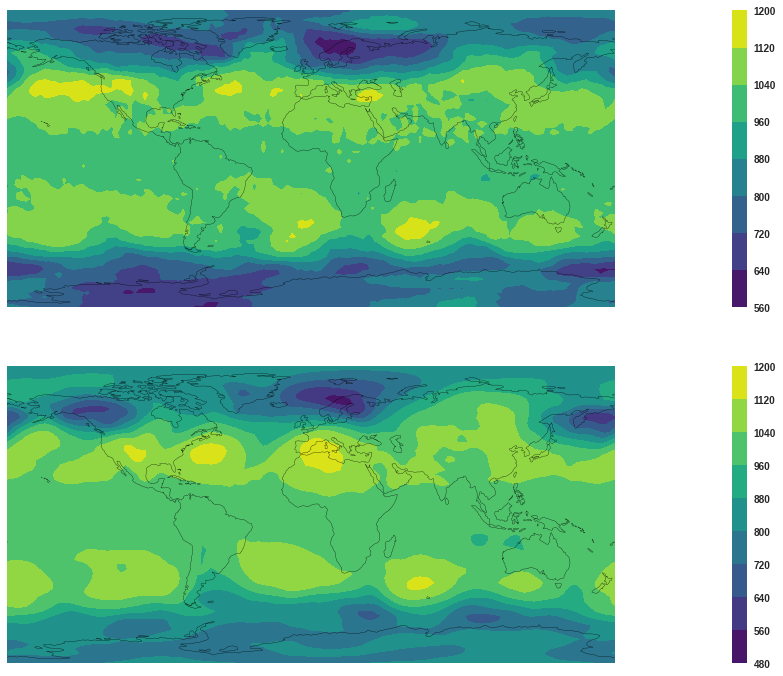

In [22]:

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(42,12),
                    subplot_kw={'projection': ccrs.PlateCarree(central_longitude = 0.)})
ax[0].coastlines()
im_ = ax[0].contourf(lon,lat,im_sc[0,:,:,78], cmap='viridis', transform=ccrs.PlateCarree(central_longitude = 360.))
#plt.scatter(0,0)
plt.colorbar(im_, ax=ax[0])


ax[1].coastlines()
im_ = ax[1].contourf(lon,lat,X_train[ind,:,:,78], cmap='viridis', transform=ccrs.PlateCarree(central_longitude = 360.))
#plt.scatter(0,0)
plt.colorbar(im_, ax=ax[1])

## Zonal plot

Zonal plots are used to represent a variable averaged over the 360 degres of longitude with respect to the altitude levels and the latitude. These zonal plot can show the difference between high and low latitudes e.g. the seasonality. 

In [23]:
def zonalPlot(im, N_lvls = N_lvls, title = None):
    """Plots zonal plots for the wind and the temperature."""
    im1 = np.mean(im[:,:,0*N_lvls:0*N_lvls+N_lvls], axis = (1)) # Mean over the longitudes
    
    fig, ax = plt.subplots(2,1, figsize=(10,10))
    fig.subplots_adjust(top=0.95, wspace = 0.35, hspace = 0.3)
    plt.suptitle(title, fontweight = fontweight)
    ax = plt.subplot(211)
    plt.contourf(lat[::],lvls,np.transpose(im1[:,::]), cmap = 'rocket')
    plt.colorbar()
    plt.title('Temperature zonal', fontsize = 20, fontweight = fontweight)
    plt.ylabel('pressure level', fontsize = 20, fontweight = fontweight)
    plt.xlabel('Latitudes', fontsize = 20, fontweight = fontweight)
    plt.yticks(lvls[::-1], fontsize = 15)
    plt.xticks( fontsize = 15)
    ax.set_ylim(1000,200)
    
    im2 = np.mean(im[:,:,1*N_lvls:1*N_lvls+N_lvls], axis = (1))
    ax = plt.subplot(212)
    plt.contourf(lat[::],lvls,np.transpose(im2[:,::]), cmap = 'mako')
    plt.colorbar()
    plt.title('Zonal wind', fontsize = 20, fontweight = fontweight)
    
    plt.ylabel('pressure level', fontsize = 20, fontweight = fontweight)
    plt.xlabel('Latitudes', fontsize = 20, fontweight = fontweight)
    plt.yticks(lvls[::-1], fontsize = 15)
    plt.xticks( fontsize = 15)
    ax.set_ylim(1000,200)
    plt.savefig(f'./fig_82c/{title}.pdf')
    return

def zonalPlot4(im1, im2, N_lvls = N_lvls, title = None):
    """Plots side by side zonal plots for the wind and the temperature for two images im1, im2."""
    
    imz1 = np.mean(im1[:,:,0*N_lvls:0*N_lvls+N_lvls], axis = (1)) # Mean over the longitudes
    imz2 = np.mean(im2[:,:,0*N_lvls:0*N_lvls+N_lvls], axis = (1)) # Mean over the longitudes
    
    fig, ax = plt.subplots(2,2, figsize=(16,8))
    fig.subplots_adjust(top=0.85, left = 0.05, right = 0.95, wspace = 0.15, hspace = 0.55)
    plt.suptitle(title, fontweight = fontweight)
    ax = plt.subplot(221)
    im = ax.contourf(lat[::],lvls,np.transpose(imz1[:,::]), cmap = 'rocket')
    plt.colorbar(im)
    plt.title('(a) \n Temperature', fontsize = 20, fontweight = fontweight)
    plt.ylabel('pressure level', fontsize = 15, fontweight = fontweight)
    plt.xlabel('Latitudes', fontsize = 15, fontweight = fontweight)
    plt.yticks(lvls[::-1], fontsize = 10)
    plt.xticks( fontsize = 10)
    ax.set_ylim(1000,100)
    
    ax = plt.subplot(222)
    im = ax.contourf(lat[::],lvls,np.transpose(imz2[:,::]),im.levels, cmap = 'rocket')
    plt.colorbar(im)
    plt.title('(b) \n Temperature', fontsize = 20, fontweight = fontweight)
    plt.ylabel('pressure level', fontsize = 15, fontweight = fontweight)
    plt.xlabel('Latitudes', fontsize = 15, fontweight = fontweight)
    plt.yticks(lvls[::-1], fontsize = 10)
    plt.xticks( fontsize = 10)
    ax.set_ylim(1000,100)
    
    imz1_ = np.mean(im1[:,:,1*N_lvls:1*N_lvls+N_lvls], axis = (1)) # Mean over the longitudes
    imz2_ = np.mean(im2[:,:,1*N_lvls:1*N_lvls+N_lvls], axis = (1)) # Mean over the longitudes
    
    ax = plt.subplot(223)
    im = ax.contourf(lat[::],lvls,np.transpose(imz1_[:,::]), cmap = 'mako')
    plt.colorbar(im)
    plt.title('(c) \n Zonal wind ', fontsize = 20, fontweight = fontweight)
    plt.ylabel('pressure level', fontsize = 15, fontweight = fontweight)
    plt.xlabel('Latitudes', fontsize = 15, fontweight = fontweight)
    plt.yticks(lvls[::-1], fontsize = 10)
    plt.xticks( fontsize = 10)
    ax.set_ylim(1000,100)
    
    ax = plt.subplot(224)
    im = ax.contourf(lat[::],lvls,np.transpose(imz2_[:,::]),im.levels, cmap = 'mako')
    plt.colorbar(im)
    plt.title('(d) \n Zonal wind', fontsize = 20, fontweight = fontweight)
    plt.ylabel('pressure level', fontsize = 15, fontweight = fontweight)
    plt.xlabel('Latitudes', fontsize = 15, fontweight = fontweight)
    plt.yticks(lvls[::-1], fontsize = 10)
    plt.xticks( fontsize = 10)
    ax.set_ylim(1000,100)
    plt.savefig(f'./fig_82c/{title.replace(" ","_")}.pdf', bbox_inches='tight')
    return

#zonalPlot4(X_train[indx,:,:,:], fk_imgs[indf,:,:,:], N_lvls = N_lvls, title=f'Temperature and eastward wind zonals')


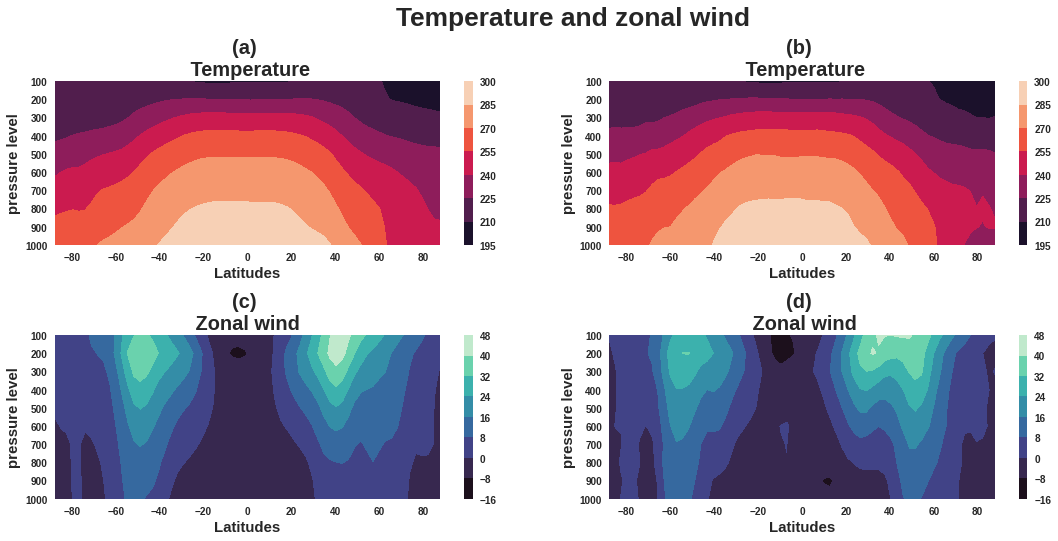

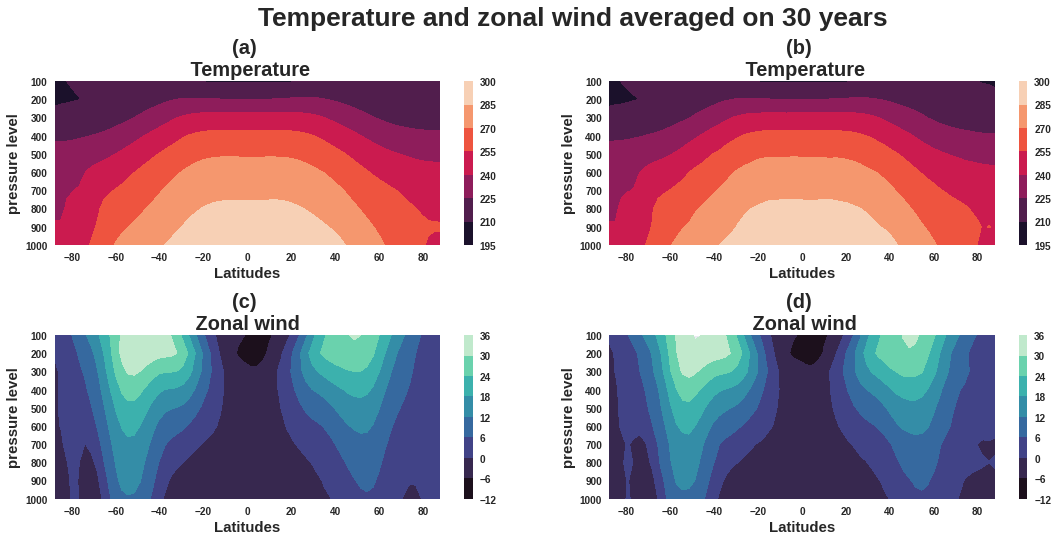

In [24]:
zonalPlot4(X_train[indx-39,:,:,:], im_sc[0,:,:,:],
           N_lvls = N_lvls, title=f'Temperature and zonal wind') # Zonal for a chosen climate state.

zonalPlot4(np.mean(X_train, axis=0), np.mean(fk_imgs, axis=0),
           N_lvls = N_lvls, title=f'Temperature and zonal wind averaged on 30 years') # Zonal averaged on dataset and generated data.

-2.98504638671875 0.9046797752380372


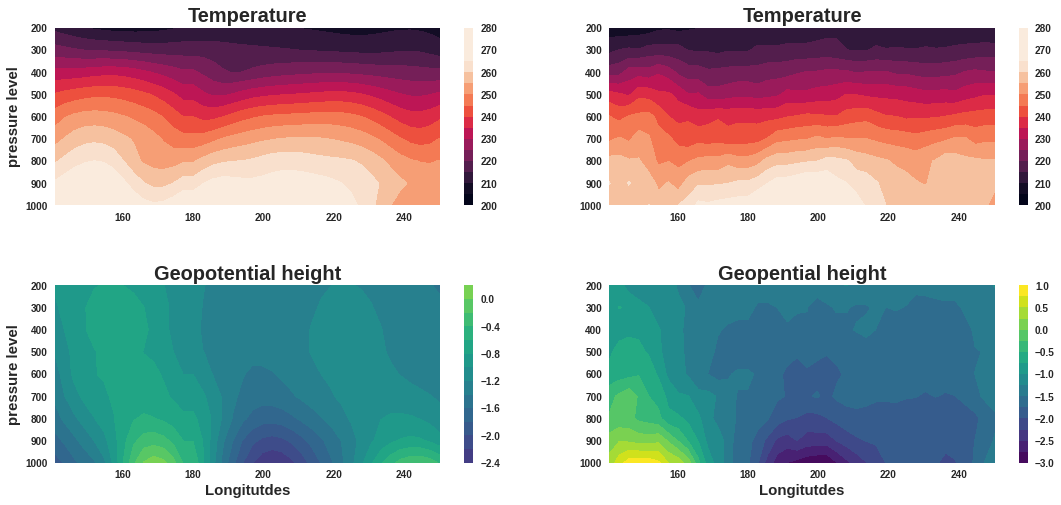

In [28]:
def geowindPlot(im1, im2, scaling, N_lvls = N_lvls, lat_ind=10, 
                 lon_ind=[[0,128],[0,128]], ind=0, title = None):
    """Plots the temperature and geopotential height on a longitude slice wrt the altitude levels."""
    
    # Translate the atmospheric fields in order to slice over Europe
    imz1 = np.roll(im1, 64, axis=1)[lat_ind[0],:,0*N_lvls:0*N_lvls+N_lvls] 
    imz2 = np.roll(im2,64,axis=1)[lat_ind[1],:,0*N_lvls:0*N_lvls+N_lvls]
    
    # Colorbar range definition
    tmin = np.amin([np.amin(im1[lat_ind[1],lon_ind[0][0]:lon_ind[0][1],0*N_lvls:0*N_lvls+N_lvls]), 
                   np.amin(im2[lat_ind[1],lon_ind[0][0]:lon_ind[0][1],0*N_lvls:0*N_lvls+N_lvls])])
    tmax = np.amax([np.amax(im1[lat_ind[1],lon_ind[0][0]:lon_ind[0][1],0*N_lvls:0*N_lvls+N_lvls]),
                    np.amax(im2[lat_ind[1],lon_ind[0][0]:lon_ind[0][1],0*N_lvls:0*N_lvls+N_lvls])])

    fig, ax = plt.subplots(2,2, figsize=(16,8))
    fig.subplots_adjust(left = 0.05, right = 0.95, wspace = 0.15, hspace = 0.45)
    plt.suptitle(title, fontweight = fontweight)
    ax = plt.subplot(221)
    im = ax.contourf(lon[lon_ind[0][0]:lon_ind[0][1]],lvls,np.transpose(imz1[lon_ind[0][0]:lon_ind[0][1],:]),
                     levels=15, cmap='rocket', vmin = tmin, vmax = tmax)
    plt.colorbar(im)
    plt.title('Temperature', fontsize = 20, fontweight = fontweight)
    plt.ylabel('pressure level', fontsize = 15, fontweight = fontweight)
    plt.yticks(lvls[::-1], fontsize = 10)
    plt.xticks( fontsize = 10)
    ax.set_ylim(1000,200)
    
    ax = plt.subplot(222)
    im = ax.contourf(lon[lon_ind[1][0]:lon_ind[1][1]],lvls,np.transpose(imz2[lon_ind[1][0]:lon_ind[1][1],:]),
                     levels=15, cmap = 'rocket', vmin = tmin, vmax = tmax)
    plt.colorbar(im)
    plt.title('Temperature', fontsize = 20, fontweight = fontweight)
    plt.yticks(lvls[::-1], fontsize = 10)
    plt.xticks( fontsize = 10)
    ax.set_ylim(1000,200)
    
    imz1_ = (np.roll(im1, 64, axis=1)[lat_ind[0],:,7*N_lvls:7*N_lvls+N_lvls]-scaling[7*N_lvls:7*N_lvls+N_lvls,0])/scaling[7*N_lvls:7*N_lvls+N_lvls,1]
    imz2_ = (np.roll(im2, 64, axis=1)[lat_ind[1],:,7*N_lvls:7*N_lvls+N_lvls]-scaling[7*N_lvls:7*N_lvls+N_lvls,0])/scaling[7*N_lvls:7*N_lvls+N_lvls,1]
    
    vmin = np.amin([np.amin(imz1_[lon_ind[0][0]:lon_ind[0][1],:]),
                    np.amin(imz2_[lon_ind[1][0]:lon_ind[1][1],:])])
    vmax = np.amax([np.amax(imz1_[lon_ind[0][0]:lon_ind[0][1],:]),
                    np.amax(imz2_[lon_ind[1][0]:lon_ind[1][1],:])])
    print(vmin,vmax)
    ax = plt.subplot(223)
    im = ax.contourf(lon[lon_ind[0][0]:lon_ind[0][1]],lvls,np.transpose(imz1_[lon_ind[0][0]:lon_ind[0][1],:]),
                     levels=15, cmap='viridis', vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title('Geopotential height', fontsize = 20, fontweight = fontweight)
    plt.ylabel('pressure level', fontsize = 15, fontweight = fontweight)
    plt.xlabel('Longitutdes', fontsize = 15, fontweight = fontweight)
    plt.yticks(lvls[::-1], fontsize = 10)
    plt.xticks( fontsize = 10)
    ax.set_ylim(1000,200)
    
    ax = plt.subplot(224)
    im = ax.contourf(lon[lon_ind[1][0]:lon_ind[1][1]],lvls,np.transpose(imz2_[lon_ind[1][0]:lon_ind[1][1],:]),
                     levels=15, cmap='viridis', vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title('Geopential height', fontsize = 20, fontweight = fontweight)
    #plt.ylabel('pressure level', fontsize = 15, fontweight = fontweight)
    plt.xlabel('Longitutdes', fontsize = 15, fontweight = fontweight)
    plt.yticks(lvls[::-1], fontsize = 10)
    plt.xticks( fontsize = 10)
    ax.set_ylim(1000,200)
    plt.savefig(f'./fig_82c/geopot_temp.pdf', bbox_inches='tight')
    return

geowindPlot(X_train[ind-360,:,:,:], im_sc[0,:,:,:], scaling, lat_ind=[9,9], lon_ind=[[50,90],[50,90]])

(2,)


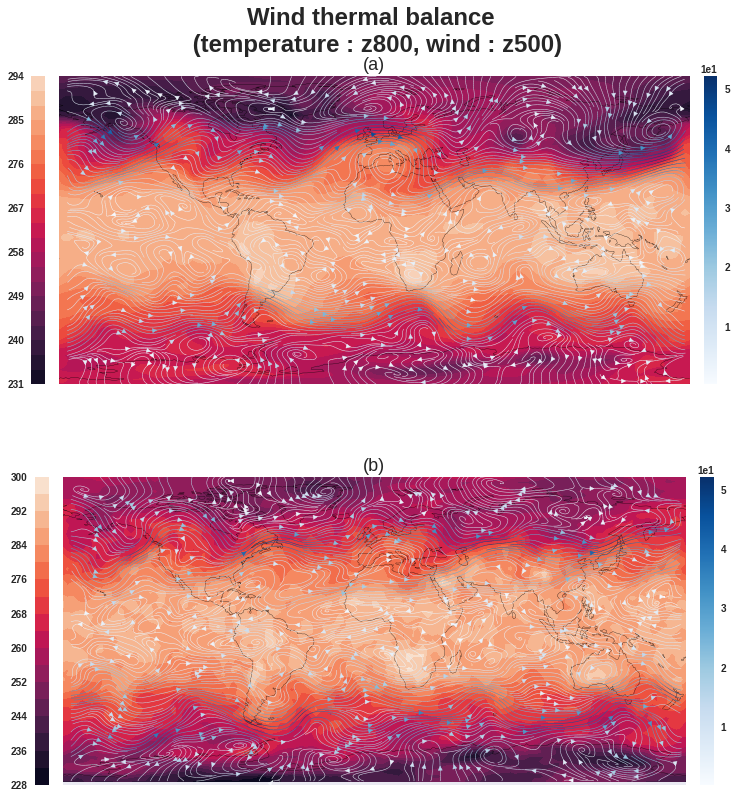

In [26]:
# Plots the temperature contours and the wind streamplot.

temp_idx = 7
wind_idx = temp_idx+N_lvls-3


tmin = np.amin([ X_train[ind,::,:,temp_idx], 
                fk_imgs[indf,::,:,temp_idx]])
tmax = np.amax([ X_train[ind,::,:,temp_idx], 
                fk_imgs[indf,::,:,temp_idx]])

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(24,12),
                    subplot_kw={'projection': ccrs.PlateCarree(central_longitude = 0.)})
ax = ax.reshape(-1)
fig.suptitle(f'Wind thermal balance \n (temperature : z800, wind : z500)', fontsize = 24, fontweight = fontweight)
fig.subplots_adjust(top = 0.9,left=0.1,right=.9,bottom=0.08, wspace = 0.35, hspace = 0.3)
print(ax.shape)

axc = ax[0]
axc.coastlines()
axc.set_title('(a)', fontsize = 18)
cim1 = axc.contourf(lon, lat, X_train[ind,::,:,temp_idx], levels = 20, cmap = 'rocket', vmin=tmin, vmax=tmax,
                   transform=ccrs.PlateCarree(central_longitude=360.))

magnitude = (X_train[ind,:,:,wind_idx] ** 2 + X_train[ind,:,:,wind_idx+N_lvls] ** 2) ** 0.5
sp = axc.streamplot(lon,lat, X_train[ind,:,:,wind_idx], X_train[ind,:,:,wind_idx+N_lvls], cmap = 'Blues',
               transform=ccrs.PlateCarree(central_longitude=360.),linewidth=.5, density=5., color=magnitude)
im1 = sp.lines

posn = axc.get_position()
cax11 = fig.add_axes([posn.x0 + posn.width + 0.008, posn.y0, 0.008, posn.height])
cbar = plt.colorbar(im1, cax = cax11)
cax11.ticklabel_format( axis='both', style='sci',scilimits=(0,0),
                       useOffset=None, useLocale=None, useMathText=None)

posn = axc.get_position()
cax21 = fig.add_axes([posn.x0 - 2*0.008, posn.y0, 0.008, posn.height])
cbar = plt.colorbar(cim1, cax = cax21)

cax21.yaxis.set_ticks_position('left')

axc2 = ax[1]
axc2.set_title('(b)', fontsize = 18)
axc2.coastlines()
cim2 = axc2.contourf(lon, lat, fk_imgs[indf,::,:,temp_idx], levels = 20, cmap = 'rocket',
                     transform=ccrs.PlateCarree(central_longitude=360.))

magnitude = (fk_imgs[indf,:,:,wind_idx] ** 2 + fk_imgs[indf,:,:,wind_idx+N_lvls] ** 2) ** 0.5
sp = axc2.streamplot(lon,lat, fk_imgs[indf,:,:,wind_idx], fk_imgs[indf,:,:,wind_idx+N_lvls], cmap = 'Blues',
               transform=ccrs.PlateCarree(central_longitude=360.),linewidth=.5, density=5., color=magnitude)
im2 = sp.lines

posn = axc2.get_position()
cax12 = fig.add_axes([posn.x0 + posn.width + 0.008, posn.y0, 0.008, posn.height])
cbar = plt.colorbar(im1, cax = cax12)
cax12.ticklabel_format( axis='both', style='sci',scilimits=(0,0),
                       useOffset=None, useLocale=None, useMathText=None)

posn = axc2.get_position()
cax22 = fig.add_axes([posn.x0 - 2*0.008, posn.y0, 0.008, posn.height])
cbar = plt.colorbar(cim2, cax = cax22)
cax22.yaxis.set_ticks_position('left')
plt.savefig(f'./fig_82c/wind_thermal_balance_taz800_windz500.pdf', bbox_inches='tight')

(2,)


/home/besombes/.env/old_tf1/lib/python3.7/site-packages/ipykernel_launcher.py:68: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error in 3.6


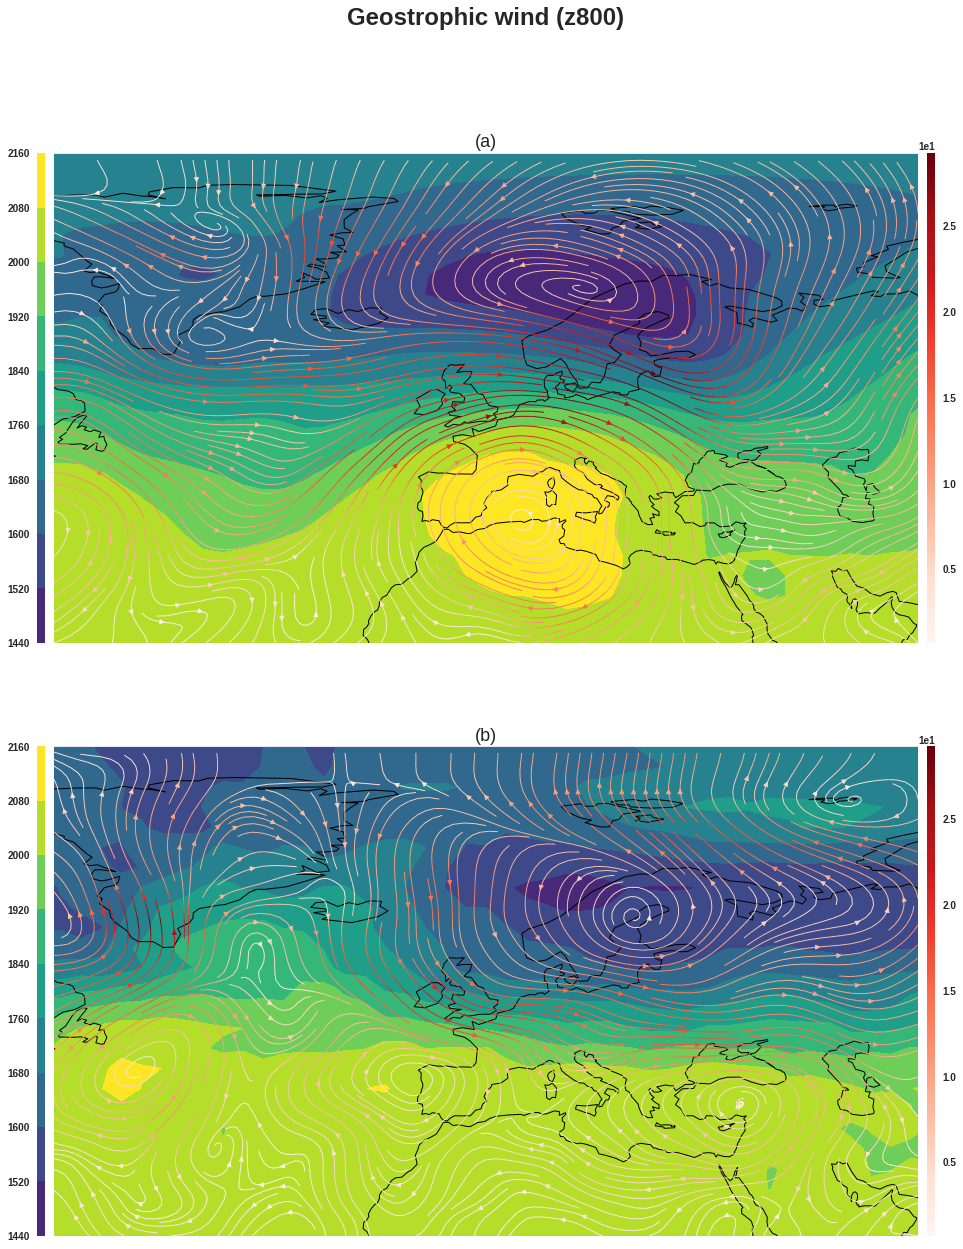

In [27]:
# Plots the geopotential height over northern Europe and the wind circulation.


temp_idx = 77
wind_idx = temp_idx+N_lvls-70

gmin = np.amin([ X_train[ind,:,:,temp_idx], 
                im[0,::,:,temp_idx]])
gmax = np.amax([ X_train[ind,::,:,temp_idx], 
                im[0,::,:,temp_idx]])
gmin = 1400
gmax = 2120
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(15,20),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude = 0.)})

ax = ax.reshape(-1)
fig.suptitle(f'Geostrophic wind (z800)', fontsize = 24, fontweight = fontweight)
fig.subplots_adjust(left=0.1,right=.9, wspace = 0.35, hspace = 0.2)
print(ax.shape)

axc = ax[0]
axc.set_extent([-60, 60, 20, 88], crs=ccrs.PlateCarree())
axc.coastlines(linewidth = 1.)
axc.set_title('(a)', fontsize = 18)
cim1 = axc.contourf(lon, lat, X_train[ind,:,:,temp_idx], levels = 8, cmap = 'viridis',  vmin=gmin, vmax=gmax,
                   transform=ccrs.PlateCarree(central_longitude=360.))

magnitude = (X_train[ind,:,:,wind_idx] ** 2 + X_train[ind,:,:,wind_idx+N_lvls] ** 2) ** 0.5
sp = axc.streamplot(lon,lat, X_train[ind,:,:,wind_idx], X_train[ind,:,:,wind_idx+N_lvls], cmap = 'Reds',
               transform=ccrs.PlateCarree(central_longitude=360.),linewidth=.95, density=2.5, color=magnitude)
im1 = sp.lines

posn = axc.get_position()
cax11 = fig.add_axes([posn.x0 + posn.width + 0.008, posn.y0, 0.008, posn.height])
cbar = plt.colorbar(im1, cax = cax11)
cax11.ticklabel_format( axis='both', style='sci',scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
#cax11.yaxis.set_ticks_position('left')

posn = axc.get_position()
cax21 = fig.add_axes([posn.x0 - 2*0.008, posn.y0, 0.008, posn.height])
cbar = plt.colorbar(cim1, cax = cax21)
#cax21.ticklabel_format( axis='both', style='sci',scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
cax21.yaxis.set_ticks_position('left')
#cbar = plt.colorbar(im1)

#axc = plt.subplot(212)
axc2 = ax[1]
axc2.set_extent([-60, 60, 20, 88], crs=ccrs.PlateCarree())
axc2.set_title('(b)', fontsize = 18)
#axc = [1].axes(projection=ccrs.PlateCarree(central_longitude=0.))
axc2.coastlines(linewidth = 1.)
cim2 = axc2.contourf(lon, lat, im[0,:,:,temp_idx]*scaling[temp_idx,1]+scaling[temp_idx,0], vmin=gmin, vmax=gmax,
                     levels = cim1.levels, cmap = 'viridis', transform=ccrs.PlateCarree(central_longitude=360.))

magnitude = (im[0,:,:,wind_idx] ** 2 + im[0,:,:,wind_idx+N_lvls] ** 2) ** 0.5
sp = axc2.streamplot(lon,lat, im[0,:,:,wind_idx], im[0,:,:,wind_idx+N_lvls], cmap = 'Reds',
               transform=ccrs.PlateCarree(central_longitude=360.),linewidth=0.95, density=2.5, color=magnitude)
im2 = sp.lines

posn = axc2.get_position()
cax12 = fig.add_axes([posn.x0 + posn.width + 0.008, posn.y0, 0.008, posn.height])
cbar = plt.colorbar(im1, cax = cax12)
cax12.ticklabel_format( axis='both', style='sci',scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
#cax12.yaxis.set_ticks_position('left')

posn = axc2.get_position()
cax22 = fig.add_axes([posn.x0 - 2*0.008, posn.y0, 0.008, posn.height])
cbar = plt.colorbar(cim2, cax = cax22)
#cax22.ticklabel_format( axis='both', style='sci',scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
cax22.yaxis.set_ticks_position('left')
plt.savefig(f'./fig_82c/geostrophic_wind_z800.pdf', bbox='tight')